<a target="_blank" href="https://colab.research.google.com/github/sonder-art/fdd_p25/blob/main/professor/numpy/notebooks/tarea_tiempos_numpy.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


### El proyecto se entrega en un pull-request en este documento directamente, que no sea del main branch sino de un branch llamado `proyecto_python`, y el titulo de pull reques `Proyecto Python`, se entrega antes del 6 de noviembre.

# Tarea/Proyecto — Tiempos con distintas estrategias (Python vs NumPy)

Objetivo: practicar varias formas de programar en Python y comparar su rendimiento con NumPy.

Qué harás:
- Implementar 3 problemas (P1 sencillo, P2 intermedio, P3 un poco más complejo).
- Para cada problema, crear 4 versiones: for, list comprehension, generator (yield/generador), y NumPy vectorizado.
- Medir tiempos con `timeit` de forma justa y compararlos.

Reglas mínimas:
- Verifica primero que todas las versiones producen el mismo resultado lógico (mismo tamaño/forma, mismos valores o valores equivalentes).
- Sé consistente: no mezcles listas y arreglos sin aclarar el formato final esperado.
- Para medir generadores, materializa con `list(...)` en el cronómetro para compararlo con las otras estrategias.
- No copies soluciones externas; escribe tu implementación.

Referencia: `07_Vectorizacion_vs_For_vs_Comprehensions.ipynb`.



In [1]:
import numpy as np
import timeit
import json
from datetime import datetime
import sys
import platform

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

## Problema 1 — Escalar un vector por una constante

Descripción: dado un arreglo 1D `a` y una constante escalar `c`, produce una salida equivalente a `a * c`.

Requisitos:
- Entrada: `a` (1D), `c` (float/int).
- Salida: misma longitud que `a`, valores escalados por `c`.
- Mantén el tipo de salida consistente entre versiones (lista vs ndarray), o documenta la diferencia.

Implementa 4 versiones:
- for loop (acumula resultados con append)
- list comprehension
- generator (yield o expresión generadora)
- NumPy vectorizado

Datos sugeridos: `a = np.arange(n, dtype=float)`, `c = 2.0`.


In [10]:
def p1_for(a: np.ndarray, c: float):
    result = []
    for val in a:
        result.append(val * c)
    return result


def p1_comp(a: np.ndarray, c: float):
    return [val * c for val in a]


def p1_gen(a: np.ndarray, c: float):
    return (val * c for val in a)


def p1_np(a: np.ndarray, c: float):
    return a * c

In [14]:
# P1 — Harness de tiempos (ajusta n y number)

def time_p1(n=100_000, number=5):
    a = np.arange(n, dtype=float)
    c = 2.0
    return (
        timeit.timeit(lambda: p1_for(a, c), number=number),
        timeit.timeit(lambda: p1_comp(a, c), number=number),
        timeit.timeit(lambda: list(p1_gen(a, c)), number=number),
        timeit.timeit(lambda: p1_np(a, c), number=number),
    )

time_p1()  # descomenta para probar


(0.060698249988490716,
 0.04133312500198372,
 0.049199665983906016,
 0.001460499974200502)

## Problema 2 — Suma de vecinos 1D (ventana)

Descripción: dado `a` (1D) y una ventana `k` impar (p. ej. 3), calcular `b[i]` como la suma de los `k` vecinos centrados en `i`.

Requisitos:
- Entrada: `a` (1D), `k` impar ≥ 3.
- Borde: puedes ignorar índices fuera de rango, recortar el resultado o replicar/extender bordes; explica tu elección.
- Salida: 1D; documenta si su longitud cambia por tu manejo de bordes.

Implementa 4 versiones: for, list comprehension, generator, NumPy vectorizado (pistas: slicing con desplazamientos, `np.roll`, o una convolución simple).

Datos sugeridos: `a = np.arange(n, dtype=float)`, `k = 3`. 


In [19]:
def p2_for(a: np.ndarray, k: int = 3):
    result = []
    n = len(a)
    offset = k // 2
    
    for i in range(offset, n - offset):
        window_sum = 0
        for j in range(i - offset, i + offset + 1):
            window_sum += a[j]
        result.append(window_sum)
    
    return result


def p2_comp(a: np.ndarray, k: int = 3):
    n = len(a)
    offset = k // 2
    return [sum(a[i - offset:i + offset + 1]) 
            for i in range(offset, n - offset)]


def p2_gen(a: np.ndarray, k: int = 3):
    n = len(a)
    offset = k // 2
    return (sum(a[i - offset:i + offset + 1]) 
            for i in range(offset, n - offset))


def p2_np(a: np.ndarray, k: int = 3):
    offset = k // 2

    result = np.zeros(len(a) - 2 * offset)
    
    for i in range(k):
        result += a[i:len(a) - 2 * offset + i]
    
    return result

In [20]:
# P2 — Harness de tiempos

def time_p2(n=100_000, number=3):
    a = np.arange(n, dtype=float)
    k = 3
    return (
        timeit.timeit(lambda: p2_for(a, k), number=number),
        timeit.timeit(lambda: p2_comp(a, k), number=number),
        timeit.timeit(lambda: list(p2_gen(a, k)), number=number),
        timeit.timeit(lambda: p2_np(a, k), number=number),
    )

time_p2()  # descomenta para probar


(0.19259845901979133,
 0.25491499999770895,
 0.27094941699760966,
 0.000582417007535696)

## Problema 3 — Transformación no lineal y filtrado

Descripción: dado `a` (1D float), aplica una transformación no lineal y filtra con un umbral.

Requisitos:
- Transformación propuesta (de ejemplo): `np.sin(a) + a**2`.
- Entrada: `a` (1D float), `umbral` (float).
- Salida: colección con los elementos resultantes que superan `umbral`.
- Mantén clara la diferencia entre devolver lista vs ndarray.

Implementa 4 versiones: for, list comprehension, generator, NumPy vectorizado (ufuncs + máscara booleana).

Datos sugeridos: `a = np.linspace(0, 1000, n)`, `umbral = 10.0`. 


In [21]:
def p3_for(a: np.ndarray, umbral: float):
    result = []
    for val in a:
        transformed = np.sin(val) + val**2
        if transformed > umbral:
            result.append(transformed)
    return result


def p3_comp(a: np.ndarray, umbral: float):
    """List comprehension."""
    return [np.sin(val) + val**2 
            for val in a 
            if np.sin(val) + val**2 > umbral]


def p3_gen(a: np.ndarray, umbral: float):
    """Generator (gen expr)."""
    return (np.sin(val) + val**2 
            for val in a 
            if np.sin(val) + val**2 > umbral)


def p3_np(a: np.ndarray, umbral: float):
    transformed = np.sin(a) + a**2
    return transformed[transformed > umbral]




In [22]:
# P3 — Harness de tiempos

def time_p3(n=200_000, number=3):
    a = np.linspace(0, 1000, n, dtype=float)
    umbral = 10.0
    return (
        timeit.timeit(lambda: p3_for(a, umbral), number=number),
        timeit.timeit(lambda: p3_comp(a, umbral), number=number),
        timeit.timeit(lambda: list(p3_gen(a, umbral)), number=number),
        timeit.timeit(lambda: p3_np(a, umbral), number=number),
    )
time_p3()  # descomenta para probar


(0.43433949997415766,
 1.2128397499909624,
 0.8025216670066584,
 0.010821832984220237)

In [26]:
def validate_implementations():
    print("Validando...")
    
    # P1
    a1 = np.arange(100, dtype=float)
    c = 2.0
    r_for = p1_for(a1, c)
    r_comp = p1_comp(a1, c)
    r_gen = list(p1_gen(a1, c))
    r_np = p1_np(a1, c)
    
    assert np.allclose(r_for, r_comp), "P1: for != comp"
    assert np.allclose(r_for, r_gen), "P1: for != gen"
    assert np.allclose(r_for, r_np), "P1: for != numpy"
    print("✓ P1 ok")
    
    # P2
    a2 = np.arange(100, dtype=float)
    r_for = p2_for(a2, 3)
    r_comp = p2_comp(a2, 3)
    r_gen = list(p2_gen(a2, 3))
    r_np = p2_np(a2, 3)
    
    assert np.allclose(r_for, r_comp), "P2: for != comp"
    assert np.allclose(r_for, r_gen), "P2: for != gen"
    assert np.allclose(r_for, r_np), "P2: for != numpy"
    print("✓ P2 oki")
    
    # P3
    a3 = np.linspace(0, 100, 1000, dtype=float)
    umbral = 10.0
    r_for = p3_for(a3, umbral)
    r_comp = p3_comp(a3, umbral)
    r_gen = list(p3_gen(a3, umbral))
    r_np = p3_np(a3, umbral)
    
    assert np.allclose(r_for, r_comp), "P3: for != comp"
    assert np.allclose(r_for, r_gen), "P3: for != gen"
    assert np.allclose(r_for, r_np), "P3: for != numpy"
    print("✓ P3 ok")
    
    print("\nAll G\n")
    
validate_implementations()


Validando...
✓ P1 ok
✓ P2 oki
✓ P3 ok

All G



## Guardar resultados de tiempos en JSON (guía)

Motivación: conservar resultados de experimentos para compararlos más tarde (en otra sesión/equipo), graficarlos o compartirlos. JSON es legible, portable y fácil de procesar.

### Esquema sugerido de datos

- Nivel 1: metadatos del experimento (fecha/hora, versión de Python/NumPy, host, parámetros globales como `n` y `number`).
- Nivel 2: problemas y variantes (p1/p2/p3 y estrategias: for/comp/gen/numpy) con sus tiempos agregados.
- Recomendación: guardar mediana y desviación o percentiles; también puedes guardar el vector de repeticiones si lo necesitas.

```json
{
  "metadata": {
    "timestamp": "2025-10-23T12:34:56Z",
    "python_version": "3.10.12",
    "numpy_version": "2.1.1",
    "machine": "x86_64",
    "params": { "n": 100000, "number": 5 }
  },
  "results": {
    "p1": {
      "for":    { "s_per_call_median": 0.0281, "repetitions": 5 },
      "comp":   { "s_per_call_median": 0.0250, "repetitions": 5 },
      "gen":    { "s_per_call_median": 0.0312, "repetitions": 5 },
      "numpy":  { "s_per_call_median": 0.0004, "repetitions": 5 }
    },
    "p2": { "for": { "s_per_call_median": 0.041 } },
    "p3": { "numpy": { "s_per_call_median": 0.003 } }
  }
}
```

Notas:
- Usa claves en minúsculas y sin espacios para facilitar procesamiento.
- Si guardas vectores de tiempos por repetición, usa una clave adicional (por ejemplo `raw_times: [ ... ]`).
- Si diferencias por tamaño `n`, crea múltiples entradas o anida por `n` (p. ej. `results_by_n: {"1e4": {...}, "1e5": {...}}`).

### Organización de archivos

- Carpeta: `results/tiempos/` dentro del mismo directorio del notebook.
- Nombre de archivo: incluir fecha, problema o tamaño (p. ej., `tiempos_p123_n1e5_2025-10-23.json`).
- Evita sobreescribir: si vuelves a correr, genera un nuevo archivo con timestamp.

### Buenas prácticas al medir y guardar

- Medir varias repeticiones por variante; guardar la mediana (y opcionalmente percentiles como p10/p90) para robustez.
- Registrar parámetros que afectan el resultado: `n`, `number`, dtype, política de bordes en P2, etc.
- Guardar seeds o condiciones de entorno si hay aleatoriedad.
- Validar que los resultados lógicos son equivalentes antes de medir (mismo output).
- No mezclar E/S dentro de la sección medida; la E/S sesga los tiempos.

### Uso posterior

- Leer los JSON y comparar versiones/estrategias; graficar con `matplotlib`/`seaborn`.
- Automatizar reportes que lean todos los archivos de `results/tiempos/` y generen tablas comparativas.
- Mantener un historial temporal para ver regresiones o mejoras de rendimiento.



## Guía de medición y reporte

- Usa `timeit.timeit` con el mismo `number` de repeticiones para todas las versiones.
- Antes de medir, ejecuta cada función una vez (warm‑up) si tu entorno lo requiere.
- Reporta tiempos en una tabla simple o tupla por problema: `(for, comp, gen, numpy)`.
- Interpreta resultados: ¿qué versión gana?, ¿por cuánto?, ¿cambia con `n`?
- Evita medir al mismo tiempo código que imprime o muestra gráficos.

Sugerencia: prueba varios tamaños `n` (por ejemplo: 10^4, 10^5, 10^6) y observa tendencias.


Aquí tienes una versión mejorada —más clara, profesional y fluida— de tu descripción, manteniendo todo el contenido técnico pero con mejor redacción, estructura y tono didáctico:

---

## Guía de visualización con Seaborn y Matplotlib 

**Objetivo:**
Utilizar los tiempos almacenados en formato JSON para **visualizar y analizar el rendimiento de distintas estrategias**, aprendiendo por tu cuenta a usar **Seaborn** y **Matplotlib**.
Esta guía explica **qué graficar**, **cómo interpretar los resultados** y **qué investigar** en la documentación oficial. *(No se proporciona código.)*

---

### 1️⃣ Preparación conceptual de los datos (formato “largo” o *tidy data*)

Antes de graficar, imagina tu tabla en formato largo, ideal para Seaborn.
Cada fila debe representar una observación o una agregación (por ejemplo, la mediana por problema, estrategia y tamaño `n`).

**Columnas sugeridas:**
`problema` (p1/p2/p3), `estrategia` (for/comp/gen/numpy), `n`, `repeticion`,
`s_por_llamada` (o `ns_por_elemento`), `mediana`, `p25`, `p75`, `host`, `python_version`, `numpy_version`.

**Investiga:** cómo transformar datos a formato largo en Seaborn, y cómo asignar columnas a ejes, color (`hue`), y paneles (`facet`).

---

### 2️⃣ Gráfico de barras agrupadas (comparación por problema)

**Qué mostrar:**
Barras agrupadas por `estrategia` dentro de cada `problema`, donde la altura sea la mediana de `s_por_llamada`.
Añade **barras de error** (p25–p75 o intervalos de confianza) para reflejar la variabilidad.

**Interpretación esperada:**
Identifica la estrategia más rápida en cada problema y comenta las diferencias relativas
(p. ej. *“NumPy es aproximadamente 60× más rápido que el bucle for en P1”*).

**Variaciones:**
Si tienes varios tamaños `n`, crea paneles por `n` o por `problema`.

---

### 3️⃣ Boxplots o Violinplots (variabilidad y outliers)

**Qué mostrar:**
Para un `problema` y `n` fijos, representa la distribución de `s_por_llamada` por `estrategia` mediante boxplots o violinplots.

**Interpretación:**
Compara la dispersión entre estrategias, detecta outliers y analiza cuál es más estable o consistente.
**Sugerencia:** agrega los puntos individuales de las repeticiones (usa *swarmplot* o *stripplot* superpuestos).

---

### 4️⃣ Curvas de escalamiento (tiempo vs tamaño `n`)

**Qué mostrar:**
Gráfico de líneas con `x = n`, `y = s_por_llamada` (o `ns_por_elemento`), y una línea por `estrategia`.
Usa escala log–log si hay grandes diferencias de magnitud.

**Interpretación:**
Compara las pendientes para ver cómo crece el tiempo con `n`.
Detecta cruces donde una estrategia empieza a superar a otra según el tamaño.

**Sugerencia:**
Usa *facets* por `problema` para comparar patrones entre P1, P2 y P3.

---

### 5️⃣ Eficiencia por elemento (`ns_por_elemento`)

**Qué mostrar:**
Gráfico de dispersión o líneas de `ns_por_elemento` frente a `n`, diferenciando por `estrategia`.

**Interpretación:**
Busca trayectorias planas (eficiencia estable).
Comenta desviaciones que puedan indicar efectos de caché, memoria o *overhead*.

---

### 6️⃣ Heatmap de razones (comparación con NumPy)

**Qué mostrar:**
Matriz donde cada celda es la razón `tiempo_estrategia / tiempo_numpy`, organizada por `problema` y `n`.

**Interpretación:**
Colorea las celdas: >1 significa más lento que NumPy; <1, más rápido.
Permite ver de un vistazo cuánto más lenta es cada alternativa y si esa relación cambia con `n`.

---

### 7️⃣ ECDF o histogramas (robustez de medición)

**Qué mostrar:**
Para un `problema` y `n` determinados, traza la **ECDF** o un **histograma** de `s_por_llamada` por `estrategia`.

**Interpretación:**
Compara la probabilidad de obtener tiempos inferiores a un umbral.
Analiza el solapamiento entre estrategias y comenta su robustez.

---

### 8️⃣ Diseño y buenas prácticas de visualización

* **Ejes y unidades:** etiqueta claramente (segundos por llamada, nanosegundos por elemento). Usa escalas logarítmicas si hay diferencias grandes.
* **Títulos y leyendas:** incluye el `problema`, `n`, entorno y fecha si es relevante. Mantén leyendas claras.
* **Paletas:** usa siempre los mismos colores por `estrategia` (orden: for → comp → gen → numpy).
* **Barras de error:** representa p25–p75 o intervalos por *bootstrap*.
* **Anotaciones:** agrega etiquetas informativas (p. ej. “×60 más rápido”).
* **Exportación:** guarda en PNG o SVG con resolución suficiente (DPI alto).

---

### 9️⃣ Interpretación (qué incluir en el reporte)

Para cada figura, redacta **4–6 frases** que respondan:

* ¿Qué estrategia es más rápida y por cuánto? ¿Cambia con `n`?
* ¿Cuál muestra menor dispersión? ¿Existen *outliers*?
* ¿Qué patrones de escalamiento aparecen? ¿Se observan efectos de memoria o caché?
* ¿Qué recomendación práctica harías según el problema?

---

### 🔟 Pistas de investigación (sin código)

Explora en la documentación de Seaborn/Matplotlib cómo:

* Crear gráficos de barras con barras de error.
* Generar boxplots o violinplots con puntos superpuestos.
* Dibujar líneas múltiples (una por `estrategia`) y facetas por `problema`.
* Aplicar escalas logarítmicas y personalizar ejes, leyendas y estilos.
* Construir heatmaps con normalización de colores para ratios.

---

### ✅ Entregables mínimos

1. **Gráfico de barras agrupadas** por `problema` (con barras de error) y su interpretación.
2. **Boxplot o violinplot** por `problema` y `n` (uno representativo) con interpretación.
3. **Curva de escalamiento** (`y` vs `n`) con facetas por `problema` e interpretación.
4. **Heatmap de razones** respecto a NumPy e interpretación.

---

**Recordatorio:**
El objetivo no es reproducir un estilo exacto, sino **demostrar criterio al elegir la visualización adecuada**, **etiquetar correctamente** e **interpretar con rigor** los resultados.

---

¿Quieres que te prepare también una versión más resumida y visual (por ejemplo, como guía para estudiantes o plantilla de trabajo)? Podría incluir íconos, ejemplos de figuras y estructura de reporte.


In [7]:
import numpy as np
import timeit
import json
import datetime
import sys
import platform
import os


def p1_for(a: np.ndarray, c: float):
    result = []
    for val in a:
        result.append(val * c)
    return result


def p1_comp(a: np.ndarray, c: float):
    return [val * c for val in a]


def p1_gen(a: np.ndarray, c: float):
    return (val * c for val in a)


def p1_np(a: np.ndarray, c: float):
    return a * c


def p2_for(a: np.ndarray, k: int = 3):
    result = []
    n = len(a)
    offset = k // 2
    
    for i in range(offset, n - offset):
        window_sum = 0
        for j in range(i - offset, i + offset + 1):
            window_sum += a[j]
        result.append(window_sum)
    
    return result


def p2_comp(a: np.ndarray, k: int = 3):
    n = len(a)
    offset = k // 2
    return [sum(a[i - offset:i + offset + 1]) 
            for i in range(offset, n - offset)]


def p2_gen(a: np.ndarray, k: int = 3):
    n = len(a)
    offset = k // 2
    return (sum(a[i - offset:i + offset + 1]) 
            for i in range(offset, n - offset))


def p2_np(a: np.ndarray, k: int = 3):
    offset = k // 2
    result = np.zeros(len(a) - 2 * offset)
    
    for i in range(k):
        result += a[i:len(a) - 2 * offset + i]
    
    return result


def p3_for(a: np.ndarray, umbral: float):
    result = []
    for val in a:
        transformed = np.sin(val) + val**2
        if transformed > umbral:
            result.append(transformed)
    return result


def p3_comp(a: np.ndarray, umbral: float):
    return [np.sin(val) + val**2 
            for val in a 
            if np.sin(val) + val**2 > umbral]


def p3_gen(a: np.ndarray, umbral: float):
    return (np.sin(val) + val**2 
            for val in a 
            if np.sin(val) + val**2 > umbral)


def p3_np(a: np.ndarray, umbral: float):
    transformed = np.sin(a) + a**2
    return transformed[transformed > umbral]


def estadisticas(vector_de_datos):
    times_array = np.array(vector_de_datos)
    return {
        "mediana": float(np.median(times_array)),
        "p25_s": float(np.percentile(times_array, 25)),
        "p75_s": float(np.percentile(times_array, 75)),
        "media": float(np.mean(times_array)),
        "std": float(np.std(times_array)),
        "vector_de_datos": [float(x) for x in vector_de_datos]
    }


def mediciones_prob1(n, repeticiones):
    a = np.arange(n, dtype=float)
    c = 2.0
    
    raw = {
        "for": timeit.repeat(lambda: p1_for(a, c), repeat=repeticiones, number=1),
        "comp": timeit.repeat(lambda: p1_comp(a, c), repeat=repeticiones, number=1),
        "gen": timeit.repeat(lambda: list(p1_gen(a, c)), repeat=repeticiones, number=1),
        "numpy": timeit.repeat(lambda: p1_np(a, c), repeat=repeticiones, number=1),
    }
    
    return {
        "for": estadisticas(raw["for"]),
        "comp": estadisticas(raw["comp"]),
        "gen": estadisticas(raw["gen"]),
        "numpy": estadisticas(raw["numpy"])
    }


def mediciones_prob2(n, repeticiones):
    a = np.arange(n, dtype=float)
    k = 3
    
    raw = {
        "for": timeit.repeat(lambda: p2_for(a, k), repeat=repeticiones, number=1),
        "comp": timeit.repeat(lambda: p2_comp(a, k), repeat=repeticiones, number=1),
        "gen": timeit.repeat(lambda: list(p2_gen(a, k)), repeat=repeticiones, number=1),
        "numpy": timeit.repeat(lambda: p2_np(a, k), repeat=repeticiones, number=1),
    }
    
    return {
        "for": estadisticas(raw["for"]),
        "comp": estadisticas(raw["comp"]),
        "gen": estadisticas(raw["gen"]),
        "numpy": estadisticas(raw["numpy"])
    }


def mediciones_prob3(n, repeticiones):
    a = np.linspace(0, 1000, n, dtype=float)
    umbral = 10.0
    
    raw = {
        "for": timeit.repeat(lambda: p3_for(a, umbral), repeat=repeticiones, number=1),
        "comp": timeit.repeat(lambda: p3_comp(a, umbral), repeat=repeticiones, number=1),
        "gen": timeit.repeat(lambda: list(p3_gen(a, umbral)), repeat=repeticiones, number=1),
        "numpy": timeit.repeat(lambda: p3_np(a, umbral), repeat=repeticiones, number=1),
    }
    
    return {
        "for": estadisticas(raw["for"]),
        "comp": estadisticas(raw["comp"]),
        "gen": estadisticas(raw["gen"]),
        "numpy": estadisticas(raw["numpy"])
    }


def metadata(rep, valores_n):
    return {
        "timestamp": datetime.datetime.now().isoformat(),
        "python_version": sys.version,
        "numpy_version": np.__version__,
        "machine": platform.platform(),
        "params": { 
            "valores_de_N_probados": valores_n,
            "repeticiones": rep,
            "timeit_number": 1
        }
    }


def validate_implementations():
    a1 = np.arange(100, dtype=float)
    c = 2.0
    r_for = p1_for(a1, c)
    r_comp = p1_comp(a1, c)
    r_gen = list(p1_gen(a1, c))
    r_np = p1_np(a1, c)
    
    assert np.allclose(r_for, r_comp), "P1: for != comp"
    assert np.allclose(r_for, r_gen), "P1: for != gen"
    assert np.allclose(r_for, r_np), "P1: for != numpy"
    
    a2 = np.arange(100, dtype=float)
    r_for = p2_for(a2, 3)
    r_comp = p2_comp(a2, 3)
    r_gen = list(p2_gen(a2, 3))
    r_np = p2_np(a2, 3)
    
    assert np.allclose(r_for, r_comp), "P2: for != comp"
    assert np.allclose(r_for, r_gen), "P2: for != gen"
    assert np.allclose(r_for, r_np), "P2: for != numpy"
    
    a3 = np.linspace(0, 100, 1000, dtype=float)
    umbral = 10.0
    r_for = p3_for(a3, umbral)
    r_comp = p3_comp(a3, umbral)
    r_gen = list(p3_gen(a3, umbral))
    r_np = p3_np(a3, umbral)
    
    assert np.allclose(r_for, r_comp), "P3: for != comp"
    assert np.allclose(r_for, r_gen), "P3: for != gen"
    assert np.allclose(r_for, r_np), "P3: for != numpy"


def ejecutar_experimento(valores_n=[10000, 100000, 1000000], rep=50):
    validate_implementations()
    
    resultados_por_n = {}
    
    for n in valores_n:
        p1 = mediciones_prob1(n, rep)
        p2 = mediciones_prob2(n, rep)
        p3 = mediciones_prob3(n, rep)
        
        resultados_por_n[str(n)] = {
            "p1": p1,
            "p2": p2,
            "p3": p3 
        }
    
    final_data = {
        "metadata": metadata(rep, valores_n),
        "resultados_por_n": resultados_por_n
    }
    
    os.makedirs('results', exist_ok=True) 
    file_date = datetime.date.today().isoformat()
    file_name = f"results/tiempos_escalamiento_{file_date}.json"
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(final_data, f, indent=2)
    
    return final_data


if __name__ == "__main__":
    ejecutar_experimento(
        valores_n=[10000, 10000, 100000],
        rep=50
    )


INTERPRETACION - GRAFICO DE BARRAS AGRUPADAS

P1:
  Estrategia mas rapida: numpy (0.000028s)
  Estrategia mas lenta: for (0.010749s)
  Diferencia relativa: 382.2x mas rapido
  NumPy vs for loop: 382.2x mas rapido

P2:
  Estrategia mas rapida: numpy (0.000121s)
  Estrategia mas lenta: comp (0.091873s)
  Diferencia relativa: 756.2x mas rapido
  NumPy vs for loop: 515.4x mas rapido

P3:
  Estrategia mas rapida: numpy (0.000770s)
  Estrategia mas lenta: gen (0.133804s)
  Diferencia relativa: 173.9x mas rapido
  NumPy vs for loop: 94.1x mas rapido


/var/folders/tm/xbxshrb90fjgngzr83cmqt4w0000gn/T/ipykernel_7037/4159012595.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=prob_data, x='estrategia', y='tiempo',
/var/folders/tm/xbxshrb90fjgngzr83cmqt4w0000gn/T/ipykernel_7037/4159012595.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=prob_data, x='estrategia', y='tiempo',
/var/folders/tm/xbxshrb90fjgngzr83cmqt4w0000gn/T/ipykernel_7037/4159012595.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=prob_data, x='estrategia', y='tiempo',



INTERPRETACION - BOXPLOT DE VARIABILIDAD

P1:
  for   : media=0.010778s, std=3.66e-04, CV=3.40%
  comp  : media=0.008080s, std=1.69e-04, CV=2.10%
  gen   : media=0.009968s, std=2.99e-04, CV=3.00%
  numpy : media=0.000028s, std=2.33e-06, CV=8.20%

P2:
  for   : media=0.062577s, std=2.96e-04, CV=0.47%
  comp  : media=0.091901s, std=4.48e-04, CV=0.49%
  gen   : media=0.083477s, std=2.79e-04, CV=0.33%
  numpy : media=0.000125s, std=1.17e-05, CV=9.33%

P3:
  for   : media=0.073147s, std=2.30e-03, CV=3.15%
  comp  : media=0.132948s, std=7.39e-04, CV=0.56%
  gen   : media=0.133806s, std=4.84e-04, CV=0.36%
  numpy : media=0.000946s, std=8.60e-04, CV=90.94%

INTERPRETACION - CURVAS DE ESCALAMIENTO

P1:
  for   : pendiente=1.030 -> complejidad aprox. O(n)
  numpy : pendiente=1.023 -> complejidad aprox. O(n)
  El speedup se mantiene estable (~379.0x)

P2:
  for   : pendiente=1.014 -> complejidad aprox. O(n)
  numpy : pendiente=0.859 -> complejidad aprox. O(n^0.86)
  El speedup AUMENTA con n (360

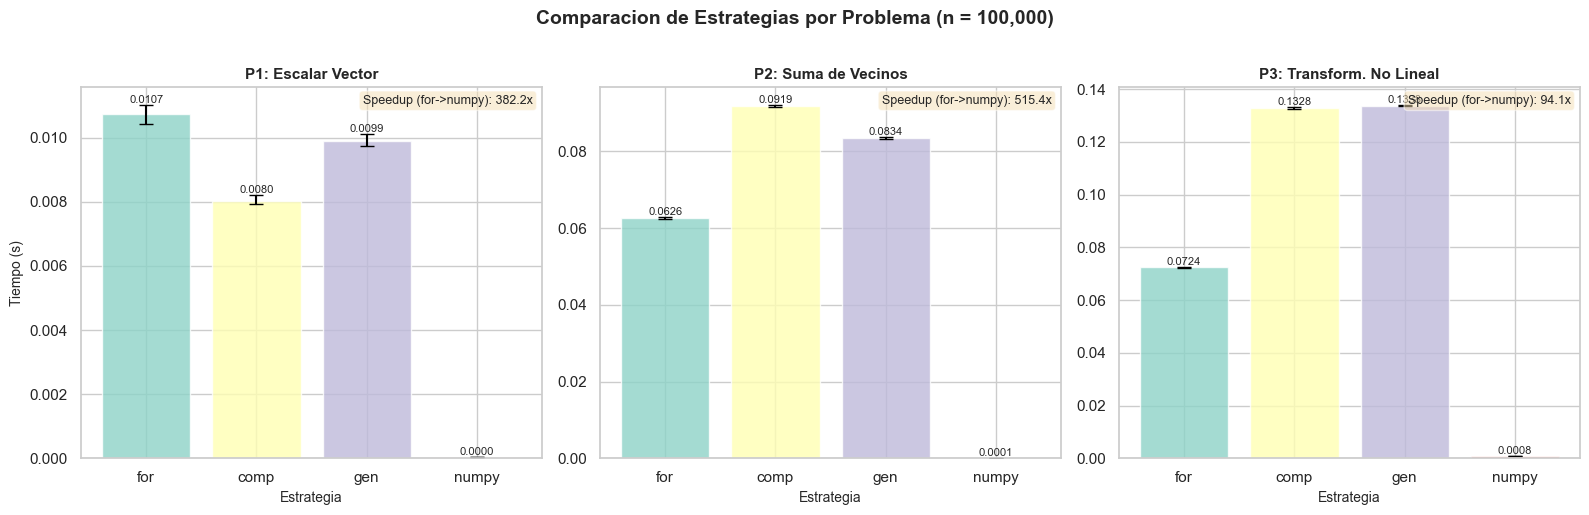

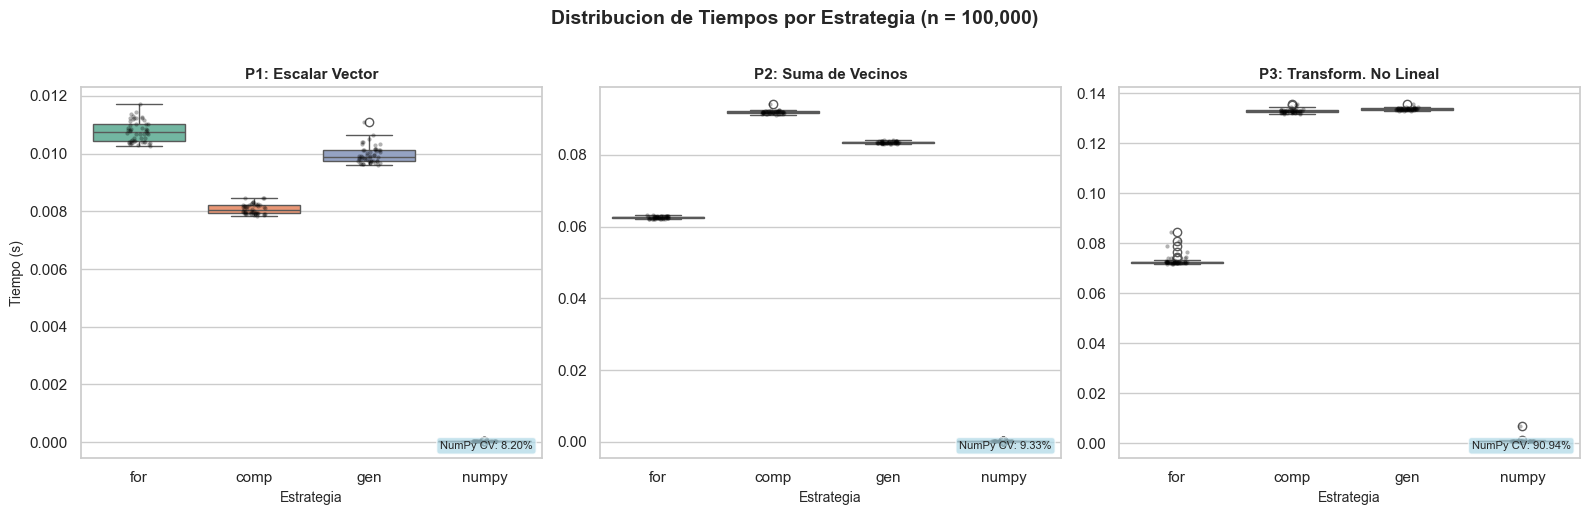

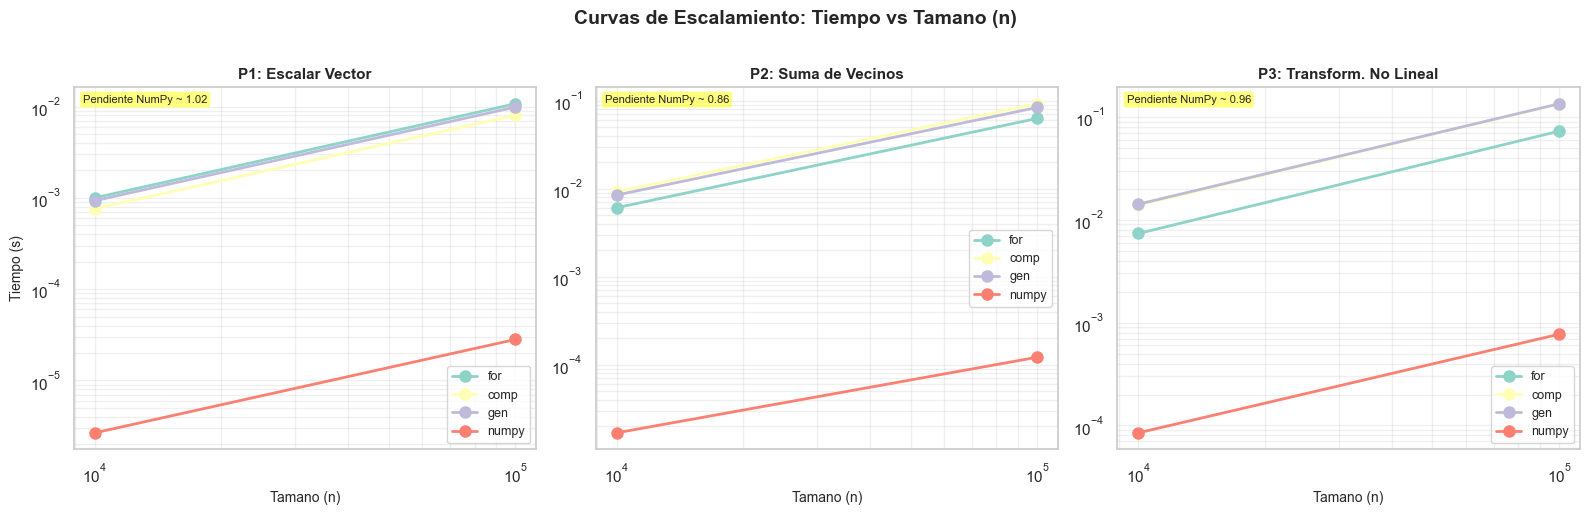

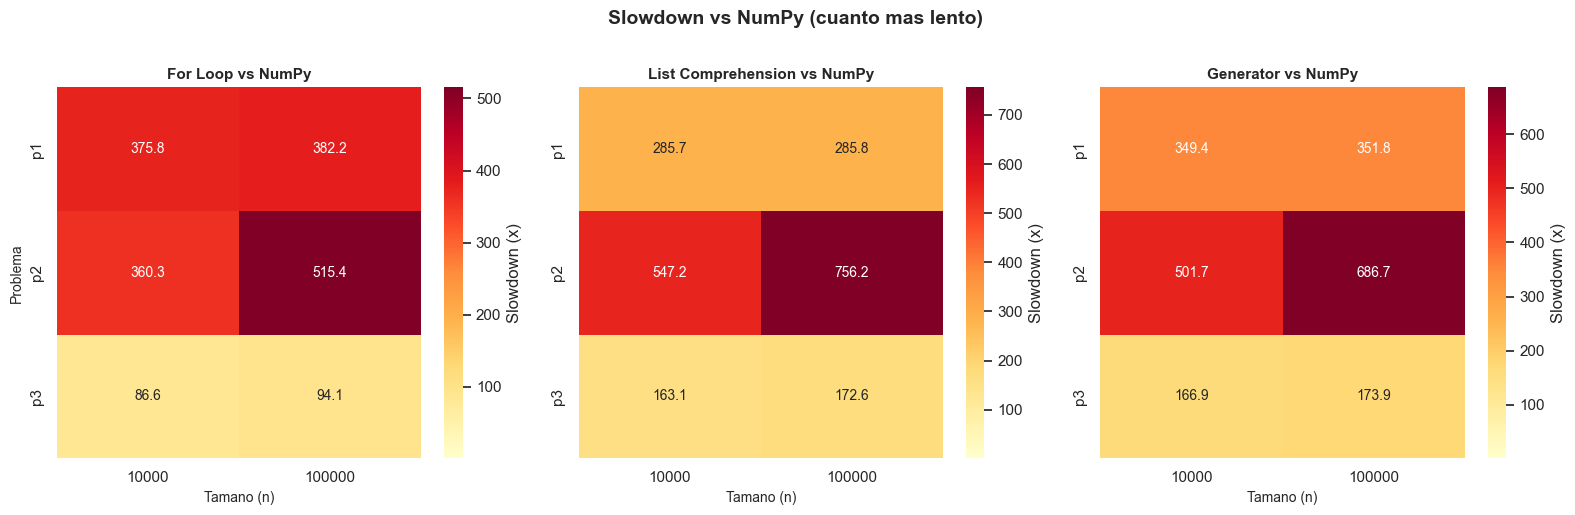

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


def load_results(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        return json.load(f)


def json_to_dataframe(results_data):
    rows = []
    
    for n_str, problems in results_data["resultados_por_n"].items():
        n = int(n_str)
        
        for prob_name, strategies in problems.items():
            for strategy, metrics in strategies.items():
                for tiempo in metrics['vector_de_datos']:
                    rows.append({
                        'n': n,
                        'problema': prob_name,
                        'estrategia': strategy,
                        'tiempo': tiempo,
                        'mediana': metrics['mediana'],
                        'p25': metrics['p25_s'],
                        'p75': metrics['p75_s'],
                        'media': metrics['media'],
                        'std': metrics['std']
                    })
    
    df = pd.DataFrame(rows)
    
    strategy_order = ['for', 'comp', 'gen', 'numpy']
    df['estrategia'] = pd.Categorical(df['estrategia'], 
                                       categories=strategy_order, 
                                       ordered=True)
    
    return df


def plot_grouped_bars(df, save_path='results/entregable_1_barras.png'):
    max_n = df['n'].max()
    df_subset = df[df['n'] == max_n].copy()
    
    df_agg = df_subset.groupby(['problema', 'estrategia'], observed=True).agg({
        'mediana': 'first',
        'p25': 'first',
        'p75': 'first'
    }).reset_index()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Comparacion de Estrategias por Problema (n = {max_n:,})', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    problems = ['p1', 'p2', 'p3']
    titles = ['P1: Escalar Vector', 'P2: Suma de Vecinos', 'P3: Transform. No Lineal']
    
    for idx, (prob, title) in enumerate(zip(problems, titles)):
        ax = axes[idx]
        prob_data = df_agg[df_agg['problema'] == prob]
        
        yerr_lower = prob_data['mediana'] - prob_data['p25']
        yerr_upper = prob_data['p75'] - prob_data['mediana']
        yerr = np.array([yerr_lower.values, yerr_upper.values])
        
        x_pos = np.arange(len(prob_data))
        bars = ax.bar(x_pos, prob_data['mediana'], 
                     yerr=yerr, capsize=5, alpha=0.8,
                     color=['#8dd3c7', '#ffffb3', '#bebada', '#fb8072'])
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(prob_data['estrategia'])
        ax.set_title(title, fontweight='bold', fontsize=11)
        ax.set_xlabel('Estrategia', fontsize=10)
        ax.set_ylabel('Tiempo (s)' if idx == 0 else '', fontsize=10)
        
        for i, (bar, val) in enumerate(zip(bars, prob_data['mediana'])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + yerr[1][i],
                   f'{val:.4f}', ha='center', va='bottom', fontsize=8)
        
        numpy_time = prob_data[prob_data['estrategia'] == 'numpy']['mediana'].values[0]
        for_time = prob_data[prob_data['estrategia'] == 'for']['mediana'].values[0]
        speedup = for_time / numpy_time
        
        ax.text(0.98, 0.98, f'Speedup (for->numpy): {speedup:.1f}x',
               transform=ax.transAxes, ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def interpret_grouped_bars(df):
    max_n = df['n'].max()
    df_subset = df[df['n'] == max_n]
    df_agg = df_subset.groupby(['problema', 'estrategia'], observed=True)['mediana'].first().reset_index()
    
    print("\nINTERPRETACION - GRAFICO DE BARRAS AGRUPADAS")
    print("="*80)
    
    for prob in ['p1', 'p2', 'p3']:
        prob_data = df_agg[df_agg['problema'] == prob]
        times = {row['estrategia']: row['mediana'] 
                for _, row in prob_data.iterrows()}
        
        fastest = min(times, key=times.get)
        slowest = max(times, key=times.get)
        speedup = times[slowest] / times[fastest]
        numpy_speedup = times['for'] / times['numpy']
        
        print(f"\n{prob.upper()}:")
        print(f"  Estrategia mas rapida: {fastest} ({times[fastest]:.6f}s)")
        print(f"  Estrategia mas lenta: {slowest} ({times[slowest]:.6f}s)")
        print(f"  Diferencia relativa: {speedup:.1f}x mas rapido")
        print(f"  NumPy vs for loop: {numpy_speedup:.1f}x mas rapido")


def plot_boxplots(df, save_path='results/entregable_2_boxplot.png'):
    available_n = sorted(df['n'].unique())
    mid_n = available_n[len(available_n)//2] if len(available_n) > 1 else available_n[0]
    df_subset = df[df['n'] == mid_n].copy()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Distribucion de Tiempos por Estrategia (n = {mid_n:,})', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    problems = ['p1', 'p2', 'p3']
    titles = ['P1: Escalar Vector', 'P2: Suma de Vecinos', 'P3: Transform. No Lineal']
    
    for idx, (prob, title) in enumerate(zip(problems, titles)):
        ax = axes[idx]
        prob_data = df_subset[df_subset['problema'] == prob]
        
        sns.boxplot(data=prob_data, x='estrategia', y='tiempo',
                   ax=ax, palette='Set2', showfliers=True)
        sns.stripplot(data=prob_data, x='estrategia', y='tiempo',
                     ax=ax, color='black', alpha=0.3, size=3)
        
        ax.set_title(title, fontweight='bold', fontsize=11)
        ax.set_xlabel('Estrategia', fontsize=10)
        ax.set_ylabel('Tiempo (s)' if idx == 0 else '', fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        
        numpy_data = prob_data[prob_data['estrategia'] == 'numpy']['tiempo']
        numpy_cv = (numpy_data.std() / numpy_data.mean() * 100)
        ax.text(0.98, 0.02, f'NumPy CV: {numpy_cv:.2f}%',
               transform=ax.transAxes, ha='right', va='bottom',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
               fontsize=8)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def interpret_boxplots(df):
    available_n = sorted(df['n'].unique())
    mid_n = available_n[len(available_n)//2] if len(available_n) > 1 else available_n[0]
    df_subset = df[df['n'] == mid_n]
    
    print("\nINTERPRETACION - BOXPLOT DE VARIABILIDAD")
    print("="*80)
    
    for prob in ['p1', 'p2', 'p3']:
        prob_data = df_subset[df_subset['problema'] == prob]
        
        print(f"\n{prob.upper()}:")
        for strategy in ['for', 'comp', 'gen', 'numpy']:
            strat_data = prob_data[prob_data['estrategia'] == strategy]['tiempo']
            mean = strat_data.mean()
            std = strat_data.std()
            cv = (std / mean * 100) if mean > 0 else 0
            
            print(f"  {strategy:6s}: media={mean:.6f}s, std={std:.2e}, CV={cv:.2f}%")


def plot_scaling_curves(df, save_path='results/entregable_3_escalamiento.png'):
    df_agg = df.groupby(['n', 'problema', 'estrategia'], observed=True)['mediana'].first().reset_index()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Curvas de Escalamiento: Tiempo vs Tamaño (n)', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    problems = ['p1', 'p2', 'p3']
    titles = ['P1: Escalar Vector', 'P2: Suma de Vecinos', 'P3: Transform. No Lineal']
    colors = {'for': '#8dd3c7', 'comp': '#ffffb3', 'gen': '#bebada', 'numpy': '#fb8072'}
    
    for idx, (prob, title) in enumerate(zip(problems, titles)):
        ax = axes[idx]
        prob_data = df_agg[df_agg['problema'] == prob]
        
        for strategy in ['for', 'comp', 'gen', 'numpy']:
            strat_data = prob_data[prob_data['estrategia'] == strategy].sort_values('n')
            ax.plot(strat_data['n'], strat_data['mediana'], 
                   marker='o', linewidth=2, markersize=8, 
                   label=strategy, color=colors[strategy])
        
        ax.set_title(title, fontweight='bold', fontsize=11)
        ax.set_xlabel('Tamaño (n)', fontsize=10)
        ax.set_ylabel('Tiempo (s)' if idx == 0 else '', fontsize=10)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3, which='both')
        
        numpy_data = prob_data[prob_data['estrategia'] == 'numpy'].sort_values('n')
        if len(numpy_data) >= 2:
            log_n = np.log10(numpy_data['n'].values)
            log_t = np.log10(numpy_data['mediana'].values)
            slope = (log_t[-1] - log_t[0]) / (log_n[-1] - log_n[0])
            ax.text(0.02, 0.98, f'Pendiente NumPy ~ {slope:.2f}',
                   transform=ax.transAxes, ha='left', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                   fontsize=8)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def interpret_scaling_curves(df):
    df_agg = df.groupby(['n', 'problema', 'estrategia'], observed=True)['mediana'].first().reset_index()
    
    print("\nINTERPRETACION - CURVAS DE ESCALAMIENTO")
    print("="*80)
    
    for prob in ['p1', 'p2', 'p3']:
        prob_data = df_agg[df_agg['problema'] == prob]
        
        print(f"\n{prob.upper()}:")
        
        for strategy in ['for', 'numpy']:
            strat_data = prob_data[prob_data['estrategia'] == strategy].sort_values('n')
            if len(strat_data) >= 2:
                log_n = np.log10(strat_data['n'].values)
                log_t = np.log10(strat_data['mediana'].values)
                slope = (log_t[-1] - log_t[0]) / (log_n[-1] - log_n[0])
                
                complexity = "O(n)" if 0.9 <= slope <= 1.1 else f"O(n^{slope:.2f})"
                print(f"  {strategy:6s}: pendiente={slope:.3f} -> complejidad aprox. {complexity}")
        
        n_values = sorted(prob_data['n'].unique())
        if len(n_values) > 1:
            speedups = []
            for n in n_values:
                n_data = prob_data[prob_data['n'] == n]
                for_time = n_data[n_data['estrategia'] == 'for']['mediana'].values[0]
                numpy_time = n_data[n_data['estrategia'] == 'numpy']['mediana'].values[0]
                speedups.append(for_time / numpy_time)
            
            if speedups[-1] > speedups[0] * 1.1:
                print(f"  El speedup AUMENTA con n ({speedups[0]:.1f}x -> {speedups[-1]:.1f}x)")
            else:
                print(f"  El speedup se mantiene estable (~{np.mean(speedups):.1f}x)")


def plot_speedup_heatmap(df, save_path='results/entregable_4_heatmap.png'):
    df_agg = df.groupby(['n', 'problema', 'estrategia'], observed=True)['mediana'].first().reset_index()
    
    ratios_data = []
    for n in sorted(df_agg['n'].unique()):
        for prob in ['p1', 'p2', 'p3']:
            subset = df_agg[(df_agg['n'] == n) & (df_agg['problema'] == prob)]
            numpy_time = subset[subset['estrategia'] == 'numpy']['mediana'].values[0]
            
            for strategy in ['for', 'comp', 'gen']:
                strat_time = subset[subset['estrategia'] == strategy]['mediana'].values[0]
                ratio = strat_time / numpy_time
                ratios_data.append({
                    'n': n,
                    'problema': prob,
                    'estrategia': strategy,
                    'ratio': ratio
                })
    
    ratios_df = pd.DataFrame(ratios_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Slowdown vs NumPy (cuanto mas lento)', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    strategies = ['for', 'comp', 'gen']
    titles = ['For Loop', 'List Comprehension', 'Generator']
    
    for idx, (strategy, title) in enumerate(zip(strategies, titles)):
        ax = axes[idx]
        strat_data = ratios_df[ratios_df['estrategia'] == strategy]
        
        pivot = strat_data.pivot(index='problema', columns='n', values='ratio')
        
        sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
                   ax=ax, cbar_kws={'label': 'Slowdown (x)'}, 
                   vmin=1, vmax=pivot.values.max())
        
        ax.set_title(f'{title} vs NumPy', fontweight='bold', fontsize=11)
        ax.set_xlabel('Tamaño (n)', fontsize=10)
        ax.set_ylabel('Problema' if idx == 0 else '', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def interpret_heatmap(df):
    df_agg = df.groupby(['n', 'problema', 'estrategia'], observed=True)['mediana'].first().reset_index()
    
    print("\nINTERPRETACION - HEATMAP DE SPEEDUPS")
    print("="*80)
    
    ratios_summary = []
    for n in sorted(df_agg['n'].unique()):
        for prob in ['p1', 'p2', 'p3']:
            subset = df_agg[(df_agg['n'] == n) & (df_agg['problema'] == prob)]
            numpy_time = subset[subset['estrategia'] == 'numpy']['mediana'].values[0]
            
            for strategy in ['for', 'comp', 'gen']:
                strat_time = subset[subset['estrategia'] == strategy]['mediana'].values[0]
                ratio = strat_time / numpy_time
                ratios_summary.append((prob, n, strategy, ratio))
    
    ratios_summary.sort(key=lambda x: x[3], reverse=True)
    
    print(f"\nMAYORES SLOWDOWNS (mas lentos vs NumPy):")
    for prob, n, strat, ratio in ratios_summary[:5]:
        print(f"  {prob} con {strat} (n={n:,}): {ratio:.1f}x mas lento")
    
    print(f"\nMENORES SLOWDOWNS (mas cercanos a NumPy):")
    ratios_summary.sort(key=lambda x: x[3])
    for prob, n, strat, ratio in ratios_summary[:5]:
        print(f"  {prob} con {strat} (n={n:,}): {ratio:.1f}x mas lento")


def generate_full_report(json_file):
    results_data = load_results(json_file)
    df = json_to_dataframe(results_data)
    
    plot_grouped_bars(df)
    interpret_grouped_bars(df)
    
    plot_boxplots(df)
    interpret_boxplots(df)
    
    plot_scaling_curves(df)
    interpret_scaling_curves(df)
    
    plot_speedup_heatmap(df)
    interpret_heatmap(df)


if __name__ == "__main__":
    results_dir = Path('results')
    json_files = list(results_dir.glob('tiempos_escalamiento_*.json'))
    
    if json_files:
        latest_file = max(json_files, key=lambda p: p.stat().st_mtime)
        generate_full_report(str(latest_file))